In [42]:
import numpy as np
import pyfits
import os
import re
import ugradio
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.interpolate
import scipy.constants as consts
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5

In [248]:
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=False)

In [43]:
path = 'maydayta'

In [44]:
def average_spec(f):
    
    '''Takes the average spectra from the open fits file.'''
    
    spec = []
    for i in range(1,21):
        spec.append(f[i].data['auto0_real'])
    
    spec = np.array(spec)
    spec.reshape(20,-1)
    avg = np.mean(spec, axis=0)
    
    return avg

In [153]:
llen = 253
blen = 41
spectra = np.zeros([llen,blen], dtype=object)
jds = np.zeros([llen,blen])

for name in os.listdir(path):
    f = pyfits.open(path+'/'+name)
    spec = average_spec(f)
    pattern = re.compile(r'-?\d+')
    nums = pattern.findall(name)
    l = int(nums[0])
    b = int(nums[2])
    bloc = b + 20
    if isinstance(spectra[l,bloc], int):
        spectra[l,bloc] = spec
        jds[l,bloc] = f[0].header['JD']

In [46]:
np.savez('allspectra.npz', data=spectra)

In [47]:
spectra = np.load('allspectra.npz')['data']

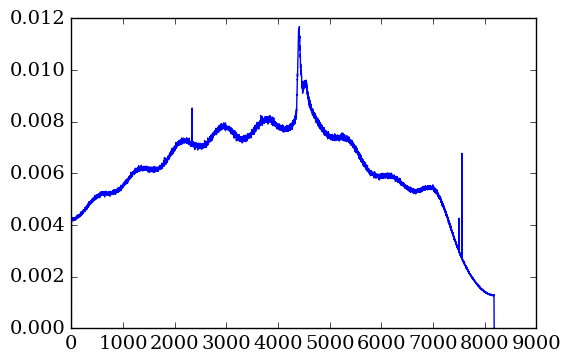

In [110]:
plt.plot(spectra[128,12])
plt.show()

# Temperature calibration

In [86]:
def gain(Tcal, scal, scold):
    
    """
    Calculates the gain value for intensity calibration 
    assuming the temperature of the sky is negligible compared
    to the temperature of the calibration source.
    :param Tcal: (int) temperature in Kelvin of the calibration
    source.
    :param scal: (array) power spectrum of the calibration source
    :param scold: (array) power spectrum of the cold sky
    :returns (float) calculated gain value of the system 
    """

    G = np.sum(scal-scold)/Tcal
    return G

In [87]:
n = pyfits.open('/home/missacarlson/Desktop/noisecal.fits')
scal = average_spec(n)

Calculating a new gain for each spectrum using only one calibration spectra results in negative values:

In [93]:
llen = 253
blen = 41
Gvals = np.zeros([llen,blen])
for i in range(llen):
    for j in range(blen):
        Gvals[i,j] = gain(30, scal, spectra[i,j])

In [95]:
print(Gvals[np.where(Gvals<0)])

[-0.06317945 -0.04302314 -0.02079698 -0.03426711 -0.01305721]


Using only one spectrum to calibrate the Gain:

In [234]:
Gain = gain(30,scal,spectra[78,12])
Gain

0.16695127107203009

In [235]:
calibratedspec = spectra/Gain

# Baseline Calibration

In [275]:
def removebaseline(spec):
    
    xdata = np.arange(len(spec))[3700:5000]
    specsec = spec[3700:5000]
    cent = specsec.argmax()
    speclow = specsec[:cent-100]
    spechigh = specsec[cent+100:]
    spectointer = np.append(speclow,spechigh)
    xlow = xdata[:cent-100]
    xhigh = xdata[cent+100:]
    xtointer = np.append(xlow,xhigh)
    interp = scipy.interpolate.interp1d(xtointer,spectointer)
    
    return specsec-interp(xdata), cent

In [276]:
shapespec = calibratedspec.shape
specnobase = np.zeros((shapespec[0],shapespec[1]),dtype='object')
peakcenters = np.zeros((shapespec[0],shapespec[1]))
observedl = []
observedb = []
for i in range(shapespec[0]):
    for j in range(shapespec[1]):
        s = calibratedspec[i,j]
        if isinstance(s,np.ndarray):
            baseresult = removebaseline(s)
            specnobase[i,j] = baseresult[0]
            peakcenters[i,j] = baseresult[1]
            observedl.append(i)
            observedb.append(j-20)

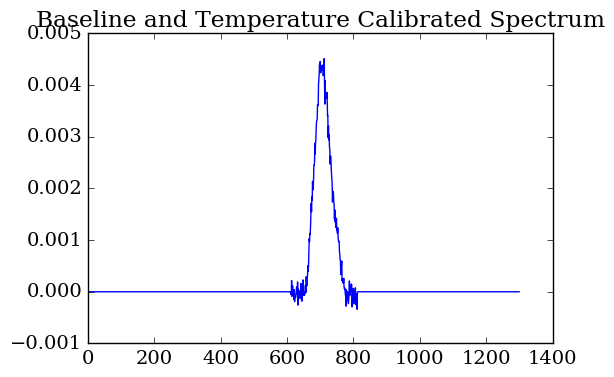

In [111]:
plt.plot(specnobase[128,12])
plt.title("Baseline and Temperature Calibrated Spectrum")
plt.show()

In [116]:
plt.figure(figsize=(10,4))
plt.scatter(observedl,observedb)
plt.title('Observed Region')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.xlim((0,260))
plt.ylim((-26,26))
plt.savefig('observed.pdf', bbox_inches='tight')

## Calibration Attempts - No Good

Trying to take out the curvy baseline by fitting a quadratic and sine wave

In [103]:
spec = calibratedspec[128,12]
x = np.arange(len(spec))
A = 1
B = 1
C = 1
D = 1
phi = 0.5
def baselinefit1(x, A, B, C):
    quad = A*x**2+B*x+C
    return quad
def baselinefit2(x,D,phi,E,F):
    return D*np.sin(F*x+phi)+E

In [104]:
xdata = np.arange(len(spec))
basefit1 = scipy.optimize.curve_fit(baselinefit1, xdata, spec)

In [105]:
params1 = basefit1[0]
A = params1[0]
B = params1[1]
C = params1[2]
fit1 = baselinefit1(xdata,A,B,C)
newspec = spec-fit1

In [106]:
D = 0.001
phi = 1.55816232e+00
E = 1.14662704e-10
F = 0.006

In [107]:
basefit2 = scipy.optimize.curve_fit(baselinefit2, xdata,newspec, p0=[D,phi,E,F])

[  1.89370326e-04  -5.75530166e-01  -1.81376358e-07   6.28751973e-03]


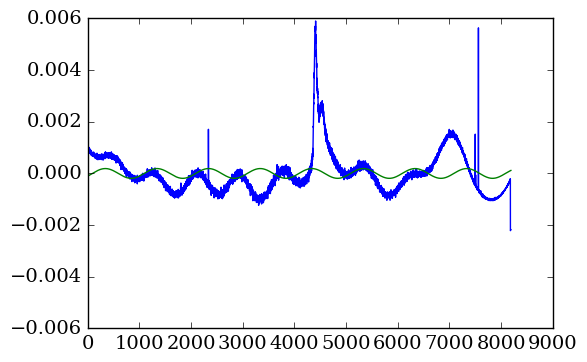

In [118]:
params2 = basefit2[0]
print(params2)

fit2 = baselinefit2(xdata,params2[0],params2[1],params2[2],params2[3])
plt.plot(xdata, newspec)
plt.plot(xdata,fit2)
plt.show()

Trying to remove baseline using interpolation

In [81]:
sec1x = xdata[:3500]
sec2x = xdata[4800:]
sec1s = newspec[:3500]
sec2s = newspec[4800:]
secx = np.append(sec1x,sec2x)
secs = np.append(sec1s,sec2s)

In [82]:
interp = scipy.interpolate.splrep(secx,secs)

In [83]:
ynew = scipy.interpolate.splev(xdata, interp, der=0)

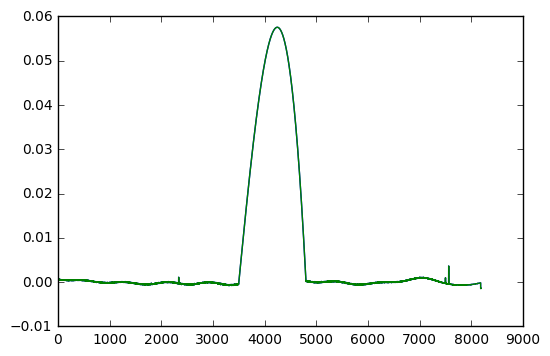

In [85]:
plt.plot(xdata,ynew)
plt.show()

# Velocities I guess?

In [119]:
llen = 253
blen = 41
freqs = np.zeros([llen,blen])

In [339]:
name = 'newnewTestMap_194.0_18.0.fits'
f = pyfits.open(path+'/'+name)
res = f[0].header['RES']
samp = f[0].header['SAMPRATE']
samp

24000000.0

In [122]:
lo = (635*2)*10e5
freq = (np.arange(-4096,4096)*res)+lo+150*10e5

In [338]:
df = freq[735]-freq[635]
df

146484.375

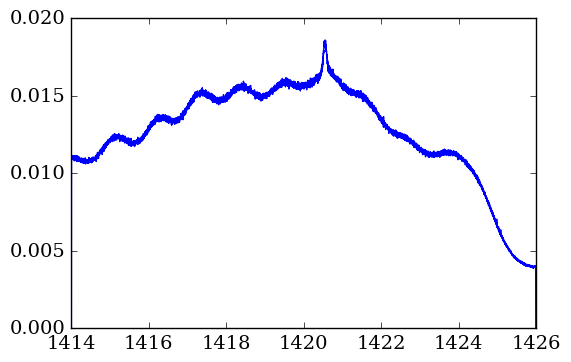

In [127]:
plt.plot(freq/10e5, calibratedspec[78,12])
plt.show()

In [128]:
c = consts.c
c

299792458.0

In [129]:
f0 = 1420.4*10e5
v = -(freq-f0)*c/f0

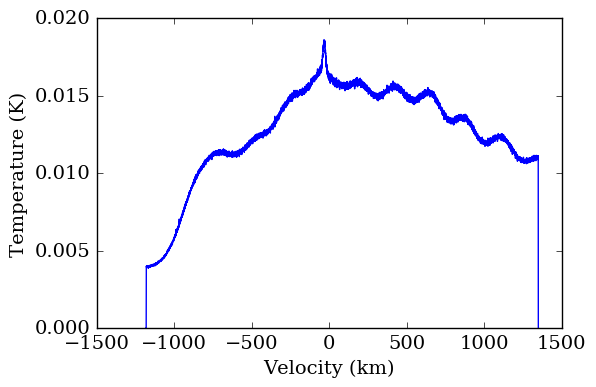

In [135]:
plt.plot(v/1000, calibratedspec[78,12])
plt.ylabel('Temperature (K)')
plt.xlabel('Velocity (km)')
plt.show()

In [166]:
l = 78
b = -8
gal = SkyCoord(l=l*u.degree, b=b*u.degree, frame='galactic')
eq  = gal.fk5
eq.transform_to(FK5(equinox='J2000'))
Ra = eq.ra.radian
Dec = eq.dec.radian
lat = ugradio.leo.lat
lon = ugradio.leo.lon
alt = ugradio.leo.alt
jd = jds[78,12]

In [167]:
vlsrcorrection = ugradio.doppler.get_projected_velocity(Ra,Dec,jd,lat,lon,alt)

In [168]:
vlsr = v - vlsrcorrection

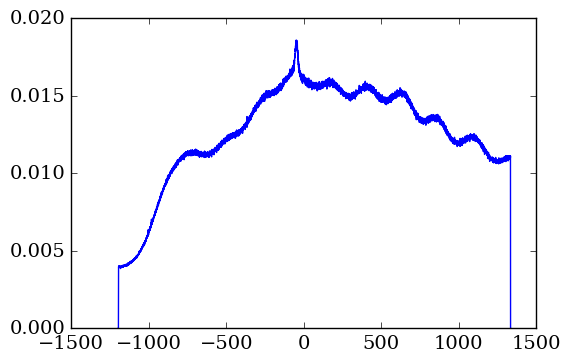

In [169]:
plt.plot(vlsr/1000, calibratedspec[78,12])
plt.show()

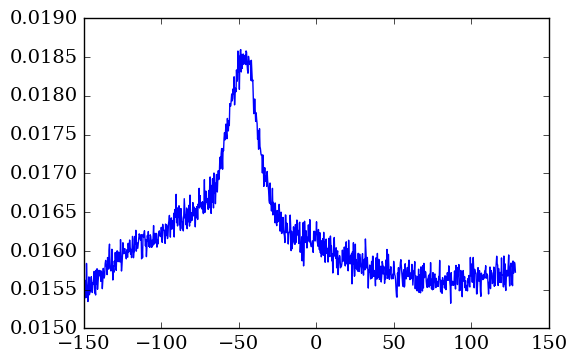

In [170]:
secs = calibratedspec[78,12][3900:4800]
secv = vlsr[3900:4800]
plt.plot(secv/1000,secs)
plt.show()

In [171]:
ampg = [0.2,0.6]
avgg = [-35000,-50000]
sigg = [370000,50000]
params = ugradio.gauss.gaussfit(secv,secs, ampg,avgg,sigg)
amp = params['amp']
avg = params['avg']
sig = params['sig']

In [172]:
gauss1 = ugradio.gauss.gaussval(secv,amp[0],avg[0],sig[0])
gauss2 = ugradio.gauss.gaussval(secv,amp[1],avg[1],sig[1])

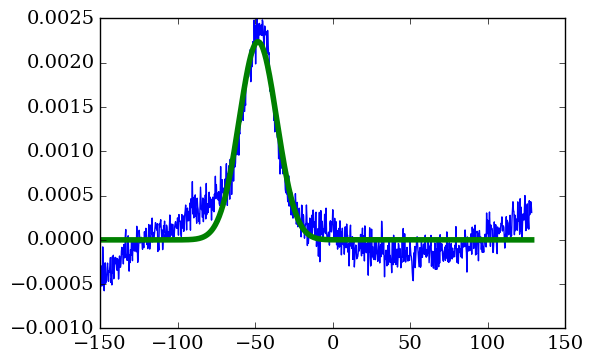

In [173]:
plt.plot(secv/1000,secs-gauss1)
#plt.plot(secv,gauss1)
plt.plot(secv/1000,gauss2,linewidth=4)
plt.show()

In [147]:
dopv = avg[1]
dopv

-44811.663281308785

In [154]:
def get_varray(l,b,spec,jd):
    
    """
    Get the velocity array for the spectra corrected to 
    the LSR frame.
    
    :param l:
    :param b:
    :param spec:
    :param jd:
    :returns: 
    
    """
    #get frequency array
    path = 'maydayta'
    name = 'newnewTestMap_194.0_18.0.fits'
    f = pyfits.open(path+'/'+name)
    res = f[0].header['RES']
    samp = f[0].header['SAMPRATE']
    lo = (635*2)*10e5
    freq = (np.arange(-4096,4096)*res)+lo+150*10e5
    
    #get velocity array
    c = consts.c
    f0 = 1420.4*10e5
    v = -(freq-f0)*c/f0
    
    #correct to lsr
    gal = SkyCoord(l=l*u.degree, b=b*u.degree, frame='galactic')
    eq  = gal.fk5
    eq.transform_to(FK5(equinox='J2000'))
    Ra = eq.ra.radian
    Dec = eq.dec.radian
    lat = ugradio.leo.lat
    lon = ugradio.leo.lon
    alt = ugradio.leo.alt
    vlsrcorrection = ugradio.doppler.get_projected_velocity(Ra,Dec,jd,lat,lon,alt)
    vlsr = v - vlsrcorrection
    
    return vlsr

In [176]:
shapespec = calibratedspec.shape
velocityarr = np.zeros((shapespec[0],shapespec[1]),dtype=object)
for i in range(shapespec[0]):
    for j in range(shapespec[1]):
        s = calibratedspec[i,j]
        if isinstance(s, np.ndarray):
            velocityarr[i,j] = get_varray(i, j-20, s, jds[i,j])

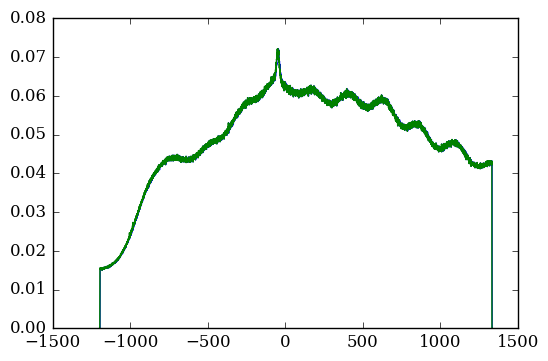

In [336]:
plt.plot(velocityarr[178,12]/1000,calibratedspec[78,12])
plt.plot(vlsr/1000,calibratedspec[78,12])
plt.show()

In [282]:
def get_doppler(velocity,spec,center):
    secv = velocity[center-100:center+100]
    secs = spec[center-100:center+100]
    ampg = [0.004]
    avgg = [-50000]
    sigg = [velocity[center-100]-velocity[center+100]]
    try:
        params = ugradio.gauss.gaussfit(secv,secs,ampg,avgg,sigg)
        amp = params['amp']
        avg = params['avg']
        sig = params['sig']
        dopv = avg[0]
        return dopv
    except:
        print(i,j,'failed')

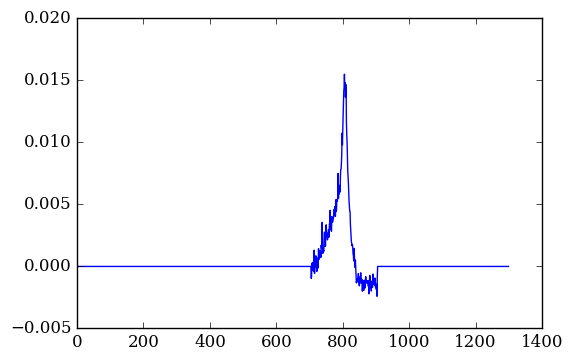

In [283]:
plt.plot(specnobase[42,6])
plt.show()

In [284]:
i=128
j=12
s = calibratedspec[i,j]
get_doppler(velocityarr[i,j],s,int(peakcenters[i,j]))

-50000.0

In [285]:
shapespec = calibratedspec.shape
dopparr = np.zeros((shapespec[0],shapespec[1]))
for i in range(shapespec[0]):
    for j in range(shapespec[1]):
        s = calibratedspec[i,j]
        if isinstance(s, np.ndarray):
            dopparr[i,j] = get_doppler(velocityarr[i,j],s,int(peakcenters[i,j]))

(220, 28, 'failed')
(224, 0, 'failed')


In [299]:
shapespec = dopparr.shape
dopplers = np.zeros((shapespec[0]+3, shapespec[1]+2))
for l in range(shapespec[0]):
    for b in range(shapespec[1]):
        v = dopparr[l,b]
        if v != 0:
            val = v
            dopplers[l,b] = val
            dopplers[l+1,b] = val
            dopplers[l+2,b] = val
            dopplers[l+3,b] = val
            dopplers[l,b+1] = val
            dopplers[l+1,b+1] = val
            dopplers[l+2,b+1] = val
            dopplers[l+3,b+1] = val

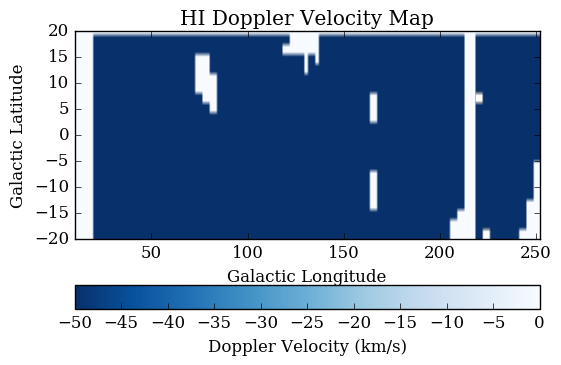

In [335]:
plt.imshow(dopplers.T/1000,aspect=2.7,cmap='Blues_r', origin='bottom', extent=[min(observedl),max(observedl),-20,20])
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('Doppler Velocity (km/s)')
plt.ylabel('Galactic Latitude')
plt.xlabel('Galactic Longitude')
plt.title('HI Doppler Velocity Map')
plt.savefig('dopplermap.pdf',bbox_inches='tight')
plt.show()

# Mapping

In [236]:
shapespec = spectra.shape
peaktemps = np.zeros((shapespec[0]+3, shapespec[1]+2))
for l in range(shapespec[0]):
    for b in range(shapespec[1]):
        s = calibratedspec[l,b]
        if isinstance(s, (np.ndarray)):
            val = max(s)
            peaktemps[l,b] = val
            peaktemps[l+1,b] = val
            peaktemps[l+2,b] = val
            peaktemps[l+3,b] = val
            peaktemps[l,b+1] = val
            peaktemps[l+1,b+1] = val
            peaktemps[l+2,b+1] = val
            peaktemps[l+3,b+1] = val

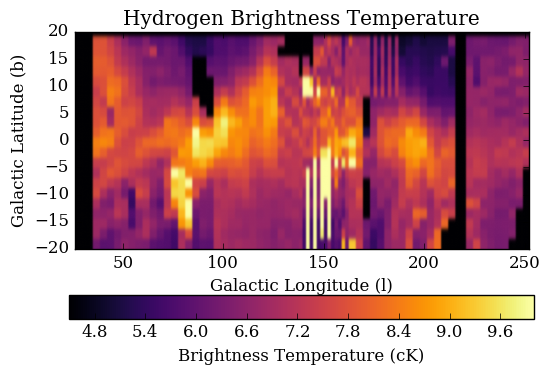

In [255]:
plt.imshow(100*peaktemps.T, origin='bottom',aspect=2.7,vmin=4.5,vmax=10, interpolation='gaussian', extent=[26,252,-20,20],cmap='inferno')
plt.ylabel("Galactic Latitude (b)")
plt.xlabel('Galactic Longitude (l)')
plt.title('Hydrogen Brightness Temperature')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('Brightness Temperature (cK)')
plt.savefig('galactic.pdf', bbox_inches='tight')
plt.show()

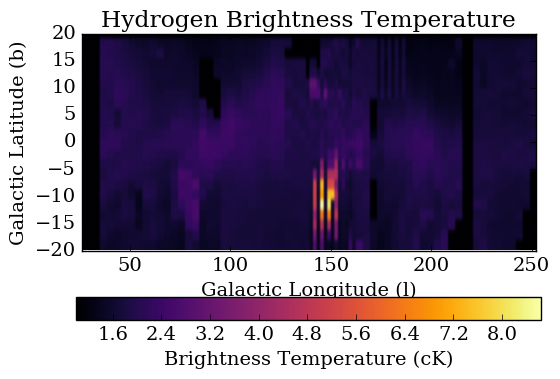

In [233]:
plt.imshow(100*peaktemps.T, origin='bottom',aspect=2.7,vmin=1, interpolation='gaussian', extent=[26,252,-20,20],cmap='inferno')
plt.ylabel("Galactic Latitude (b)")
plt.xlabel('Galactic Longitude (l)')
plt.title('Hydrogen Brightness Temperature')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('Brightness Temperature (cK)')
plt.savefig('galactic.pdf', bbox_inches='tight')
plt.show()